In [129]:
#Load libraries 

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import sspa
import scipy 
import networkx as nx


In [ ]:
#Load the whole dataset

#Metabolomics:
#df = pd.read_csv('Data/Su_COVID_metabolomics_processed.csv', index_col=0)
#df.index= df.index.str.rstrip('-BL')
#print(df.iloc[:10,-2:])    #show subset of control data (first 10 rows, last two columns)

#Proteomics:
#df = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)

In [130]:
#Load the common cases dataset
#df = pd.read_csv('../Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)

#df = pd.read_csv('../Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)

df = pd.read_csv("../Data/Su_integrated_data.csv", index_col=0)

### FOR DATA INTEGRATION STEP OR IF COMPARING BY CASE SEVERITY
### Subset the data to common samples

We make two different networks, one for the COVID cases 1-2 compared to COVID cases 3-7 <br>
This is because there are only 18 samples in common between the metabolomic and proteomic datasets

0       Common samples: 18           Metabolomic samples: 133        Proteomic samples: 123 <br>
1-2       Common samples: 45          Metabolomic samples: 45        Proteomic samples: 48 <br>
3-4       Common samples: 56          Metabolomic samples: 57        Proteomic samples: 59 <br>
5-7       Common samples: 27          Metabolomic samples: 28        Proteomic samples: 28 <br>

146 common samples overall,   128 cases, composed of (45 samples (WHO 1-2) vs 83 samples (WHO 3-7))

Subsetting the METABOLOMICS dataset to common samples and THEN CENTERING THE DATA ONCE MORE (no need to log2 transform):

In [ ]:
#df2 = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)
#list1 = list(df.index)
#list2 = list(df2.index)

#Obtain common samples and subset accordingly
#intersection = list(set(df.index.tolist()) & set(df2.index.tolist())) #set removes duplicates
#intersection = [sample for sample in intersection if sample.startswith("INCOV")]
#df = df[df.index.isin(intersection)]

#print(len(df))
#df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
#df_norm = pd.DataFrame(StandardScaler().fit_transform(df_num),columns=df_num.columns, index=df_num.index)

#Add metadata to the end of the df
#df_final = pd.concat([df_norm, df.iloc[:,-2:]],axis=1) 
#df_final.to_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv')

Subsetting the PROTEOMICS dataset to common samples and THEN CENTERING THE DATA ONCE MORE (no need to log2 transform):

In [ ]:
#df2 = pd.read_csv('Data/Su_COVID_metabolomics_processed.csv', index_col=0)
#df2.index= df2.index.str.rstrip('-BL')  #remove 'BL' label from the cases (so I can match to proteomic data)

#list1 = list(df.index)
#list2 = list(df2.index)

#Obtain common samples and subset accordingly
#intersection = list(set(df.index.tolist()) & set(df2.index.tolist())) #set removes duplicates
#intersection = [sample for sample in intersection if sample.startswith("INCOV")]
#df = df[df.index.isin(intersection)]

#print(len(df))

#df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
#df_norm = pd.DataFrame(StandardScaler().fit_transform(df_num),columns=df_num.columns, index=df_num.index)

#Add metadata to the end of the df
#df_final = pd.concat([df_norm, df.iloc[:,-2:]],axis=1) 
#df_final.to_csv('Data/Su_COVID_proteomics_processed_commoncases.csv')

Subsetting the dataframe into two groups and SCALING:

In [ ]:
df_mild = (df[df["WHO_status"] == '1-2']).iloc[:,:-2] #45 samples, remove the metadata
df_severe = (df[(df["WHO_status"] == '3-4') | (df["WHO_status"] == '5-7')]).iloc[:,:-2] #83 samples

In [ ]:
df_mild = pd.DataFrame(StandardScaler().fit_transform(df_mild),columns=df_mild.columns, index=df_mild.index)
df_severe = pd.DataFrame(StandardScaler().fit_transform(df_severe),columns=df_severe.columns, index=df_severe.index)

### Data exploration

In [3]:
print("Number of metabolites:", len(df. columns[:-2]) )
print("Number of samples:", len(df. index))

print(df['WHO_status'].value_counts()) 
print(df['Group'].value_counts())

#return non-integer columns
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

Number of metabolites: 333
Number of samples: 128
3-4    56
1-2    45
5-7    27
Name: WHO_status, dtype: int64
COVID19     128
Name: Group, dtype: int64


WHO_status    object
Group         object
dtype: object

In [4]:
def check_centred(type):
    print(type.max().max())
    print(type.min().min())
    print(type.mean(axis = 0)) #mean of 0
    print(type.std(axis = 0)) #sd of 1

In [5]:
#check_centred(df_severe)
check_centred(df.iloc[:,:-2])

10.947848832735254
-5.091869731580215
1372    -6.938894e-18
16610   -4.163336e-17
72665    4.163336e-17
27823    0.000000e+00
30915   -4.163336e-17
             ...     
28238   -3.816392e-17
76341    3.122502e-17
89312    2.428613e-17
17861    2.081668e-17
89188    6.938894e-17
Length: 333, dtype: float64
1372     1.003929
16610    1.003929
72665    1.003929
27823    1.003929
30915    1.003929
           ...   
28238    1.003929
76341    1.003929
89312    1.003929
17861    1.003929
89188    1.003929
Length: 333, dtype: float64


In [ ]:
#Histogram of mean analyte abundance (idea from Sara's thesis)

df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
df_hist = df_num.mean(axis = 0) #axis = 0 by column
sns.histplot(df_hist, bins = 30,color='#79C99E',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Mean metabolite distribution',fontsize=16)
plt.xlabel('Metabolite abundance (e-15)',fontsize=13) # USE METABOLITE ABUNDANCE INSTEAD OF METABOLITE EXPRESSION
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/mean_metabolite_distribution.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Histogram of all analyte abundance (idea from Sara's thesis)

df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
df_num_np = df_num.to_numpy()
df_hist = df_num_np.flatten()
sns.histplot(df_hist, bins = 30,color='#79C99E',edgecolor="k") 

plt.title('Metabolite distribution',fontsize=16)
plt.xlabel('Metabolite abundance',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( '../Figures/metabolite_distribution.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
metabolomic_distribution

In [8]:
#Load in sequentially to form a density plot of the three different omics
metabolomic_distribution  = df.iloc[:,:-2] #all rows, all columns apart from last two
#proteomic_distribution  = df.iloc[:,:-2] 
#integrated_distribution  = df.iloc[:,:-2] 


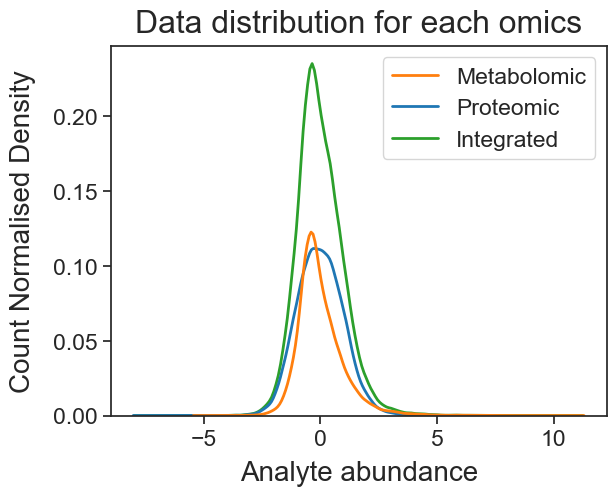

In [12]:
#Load in sequentially to form a density plot of the three different omics

sns.set(font_scale = 1.5)
sns.set_style("ticks") # same as "white" but with ticks

metabolomic_list = metabolomic_distribution.stack().reset_index()
metabolomic_list.columns.values[2] = "Metabolomic"

proteomic_list = proteomic_distribution.stack().reset_index()
proteomic_list.columns.values[2] = "Proteomic"

integrated_list = integrated_distribution.stack().reset_index()
integrated_list.columns.values[2] = "Integrated"


omics_df = pd.concat([metabolomic_list.Metabolomic, proteomic_list.Proteomic,integrated_list.Integrated], axis=1)

#Change because I want metabolomics to be orange, proteomics to be blue
palette = ['tab:orange', 'tab:blue', 'tab:green']

sns.kdeplot(data=omics_df, palette=palette, linewidth=2)

plt.title('Data distribution for each omics',  fontsize=23, pad = 10)
plt.xlabel('Analyte abundance',fontsize=20, labelpad=8)
plt.ylabel('Count Normalised Density',fontsize=20, labelpad=12) ;   #see seaborn histogram documentation on explanation of probability

plt.savefig( '../Figures/omics_molecular_distribution.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [ ]:
#Heatmap of analyte abundance according to WHO status (idea from Sara's thesis)


df_heatmap = df.groupby('WHO_status').mean(numeric_only=True)
#print(df_heatmap.iloc[:,-5:])

g = sns.clustermap(
    df_heatmap,
    metric='euclidean', 
    method ="ward",
    row_cluster=False,
    xticklabels=False,
    cmap='RdBu_r',
    figsize=(9,3),
    dendrogram_ratio=0.2, 
    vmin=-2, 
    vmax=2) 

g2 = g.ax_heatmap
g2.set_xlabel("Metabolites", fontsize = 15,labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("WHO status", fontsize = 15, labelpad=12) 
g2.set_yticklabels(g2.get_yticklabels(), rotation=0, fontsize=10)  #rotate the y-axis labels so that they are horizontal

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.28, 0.03, 0.35])
g.cax.set_title("Metabolite abundance",pad=10, size=13) #pad: increase spacing slightly
g.cax.tick_params(labelsize=10) #change font size of colourbar labels; 

#plt.savefig( 'Figures/metabolite_heatmap.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#PCA at molecular level

features = df.columns[:-2]
x = df.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

display(df3)




sns.set(font_scale = 1.7)
sns.set_style("white")

sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['1-2', '3-4','5-7'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    palette=[ '#F4C441','#ff6d00', '#a30000']   #yellow #F5AF2C #F6AE2D
   # scatter_kws={"s": 20} #point size
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend

sns.despine(right=False,top=False) #Add a line to the top and right of grid


#plt.title('Metabolomic dataset',fontsize=20,loc='center',y=1.08)
#plt.title('Metabolite abundance',fontsize=22, loc='left',pad=15)

plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=24)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=24)


#plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.5, 0.7))  
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

plt.grid()  

#plt.savefig('../Figures/integrated_PCA.png' , dpi=600,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [4]:
display(sns.axes_style("white"))

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

In [ ]:
#Obtain hex codes for sns colour palette
#https://www.practicalpythonfordatascience.com/ap_seaborn_palette
print(sns.color_palette("spring").as_hex()[:])
sns.color_palette("spring")

#print(sns.color_palette("gist_heat").as_hex()[:])
#sns.color_palette("gist_heat")

In [5]:
df

,1372,16610,72665,27823,30915,37373,16831,545959,17050,16359,...,Q9ULX7,Q9UNK0,Q9Y478,Q9Y4K4,Q9Y5A7,Q9Y5L3,Q9Y5V3,Q9Y653,WHO_status,Group
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,-0.342522,-0.830841,-0.703451,-0.451278,0.153207,-0.443252,-0.228725,0.501998,-0.861886,-0.344155,...,0.056692,-1.339019,-1.482133,-1.836151,-1.708529,-0.677567,-0.982971,1.703613,3-4,COVID19
INCOV002,-0.125585,-1.002246,0.399273,-0.828341,-0.980576,0.373921,-1.076979,-0.131876,-0.869093,-0.467326,...,-0.589103,-0.916950,-0.999042,-0.323778,-0.368824,-1.212782,-0.263024,-0.830373,5-7,COVID19
INCOV003,-0.859326,-0.409159,3.573100,-0.546783,-0.993647,1.547649,0.370131,-0.020399,-0.703786,-0.015627,...,-1.357965,-1.209485,-1.103151,-0.608847,-0.821175,-1.010808,-0.662941,1.026187,5-7,COVID19
INCOV004,-0.562999,-1.560249,-1.269383,-1.437919,0.108734,-0.192066,0.161591,-0.586759,-1.457246,-0.500612,...,0.286096,-1.880875,-1.514350,-1.686500,-1.523233,-0.877769,-1.305748,0.806740,3-4,COVID19
INCOV005,-0.741957,0.387909,-0.711036,-0.711515,0.670720,0.610591,-0.322241,-0.793451,-1.230681,-0.246493,...,-0.092095,-1.600513,-1.340302,-1.155597,-1.447396,0.293662,-0.783788,-0.612823,3-4,COVID19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,-2.075777,-0.485936,-0.671225,0.069483,0.042579,0.357250,-0.505272,-0.378441,-0.444915,-0.368108,...,1.412605,-0.208973,-0.638806,-0.789582,-0.693826,-0.374689,-1.150091,-1.031098,1-2,COVID19
INCOV136,-0.174602,1.167644,0.055499,0.113342,-0.663851,0.799367,0.004697,0.748894,1.328753,0.391221,...,0.796855,0.841765,1.359763,0.887098,1.239520,-0.831379,0.877162,1.989469,3-4,COVID19
INCOV137,0.274900,-0.014841,-0.928512,0.885263,-1.591862,0.230250,0.057818,-0.775962,-0.179700,-0.534786,...,0.518722,0.866393,0.878241,0.976843,1.191535,-0.619671,0.741753,-0.774813,5-7,COVID19


Make a PCA plot for the integrated data showing the separation of metabolomic and proteomic clusters:

In [131]:
df.iloc[:,333]

sample_id
INCOV001    0.662699
INCOV002    0.823906
INCOV003    0.493235
INCOV004    0.670326
INCOV005    0.303574
              ...   
INCOV135   -0.559506
INCOV136   -0.641303
INCOV137    0.279144
INCOV139   -1.162852
INCOV142    0.418825
Name: O00182, Length: 128, dtype: float64

In [132]:
integrated_df =  (df.iloc[:,:-2]).transpose()

analyte_list = []
for i in range(len(integrated_df)):
    if i < 333:
        analyte_list.append("Metabolite")
    if i >= 333:
        analyte_list.append("Protein")

len(analyte_list)

787

In [133]:


#PCA at molecular level
features = integrated_df.columns
x = integrated_df .loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(integrated_df.index)
display(df2)

#Concatenate WHO information

df2['Omics'] = analyte_list

display(df2)


,PC1,PC2
1372,1.472138,-1.752140
16610,6.021435,1.682032
72665,1.002267,-4.026260
27823,4.045677,-4.582564
30915,-3.610197,-1.268255
...,...,...
Q9Y4K4,8.721936,3.280872
Q9Y5A7,8.917950,3.843397
Q9Y5L3,0.181483,-0.828701
Q9Y5V3,5.432834,5.890367


,PC1,PC2,Omics
1372,1.472138,-1.752140,Metabolite
16610,6.021435,1.682032,Metabolite
72665,1.002267,-4.026260,Metabolite
27823,4.045677,-4.582564,Metabolite
30915,-3.610197,-1.268255,Metabolite
...,...,...,...
Q9Y4K4,8.721936,3.280872,Protein
Q9Y5A7,8.917950,3.843397,Protein
Q9Y5L3,0.181483,-0.828701,Protein
Q9Y5V3,5.432834,5.890367,Protein


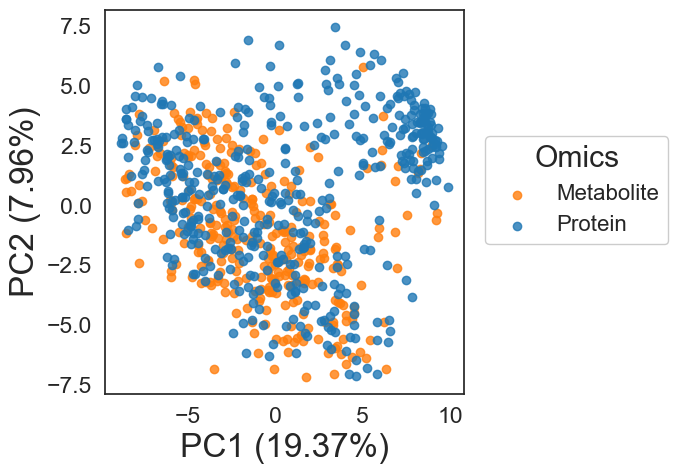

In [134]:

sns.set(font_scale = 1.5)
sns.set_style("white")

sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df2, 
    hue='Omics', 
    hue_order = ['Metabolite', 'Protein','Both'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    palette=[ '#ff7f0e','#1f77b4','#2ca02c']
   # scatter_kws={"s": 20} #point size
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend

sns.despine(right=False,top=False) #Add a line to the top and right of grid


#plt.title('Metabolomic dataset',fontsize=20,loc='center',y=1.08)
#plt.title('Metabolite abundance',fontsize=22, loc='left',pad=15)

plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=24)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=24)

plt.legend(framealpha=1, frameon = 'True', title="Omics",title_fontsize='large', prop={'size': 16}, bbox_to_anchor=(1.6, 0.7))  

### Single sample pathway analysis

If you're analysing the METABOLOMIC data:

In [73]:
#Load in the Reactome pathways for METABOLOMIC dataset

#reactome_pathways = sspa.process_reactome("Homo sapiens", download_latest=True, filepath=".")
reactome_pathways = sspa.process_gmt("../Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")
#display(reactome_pathways)

If you're analysing the PROTEOMIC data:

In [72]:
#Load in a file downloaded from https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = '../Data/UniProt2Reactome_All_Levels_ver84.txt', download_latest = False, filepath = None)


If you're analysing the INTEGRATED data:

In [102]:
#Concatenated the pathways in a separate script
reactome_pathways = pd.read_csv("../Data/Reactome_multi_omics_ChEBI_Uniprot.csv", index_col=0,dtype="str") #Dtype warning because in some columns, some values are in string format whereas some are in integer format, that's why I specify dtype="str"

In [103]:
kpca_scores = sspa.sspa_kpca(df.iloc[:,:-2], reactome_pathways)
#kpca_scores = sspa.sspa_kpca(df_severe, reactome_pathways)     
kpca_scores

,R-HSA-109581,R-HSA-109582,R-HSA-109606,R-HSA-109704,R-HSA-110331,R-HSA-110362,R-HSA-110373,R-HSA-111465,R-HSA-112310,R-HSA-112311,...,R-HSA-9818027,R-HSA-9824439,R-HSA-9824443,R-HSA-9824446,R-HSA-983168,R-HSA-983169,R-HSA-983231,R-HSA-983695,R-HSA-983705,R-HSA-983712
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,0.413536,0.450345,0.729067,0.303770,-0.376183,-0.430659,-0.430659,0.384273,0.023789,0.577936,...,0.644510,-0.481606,-0.150567,0.372096,-0.133388,0.285130,-0.434451,0.645959,0.368779,0.658221
INCOV002,0.362645,0.394150,0.055357,0.527061,-0.311560,0.638987,0.638987,0.444671,-0.092256,0.604496,...,0.491841,-0.548186,-0.533311,0.341016,-0.303490,0.433799,-0.539958,0.410963,0.457822,0.432791
INCOV003,0.575862,0.408867,0.575287,0.459731,-0.308065,-0.082800,-0.082800,0.736859,0.016257,0.304684,...,0.653922,-0.433432,-0.351057,0.286416,-0.620820,0.479704,-0.654156,0.460245,0.419668,0.335348
INCOV004,0.527632,0.380388,0.486186,0.153415,0.664277,-0.377176,-0.377176,0.479131,0.165562,0.615549,...,0.482319,-0.165577,-0.402658,0.341416,-0.233868,0.343820,-0.372565,0.439250,0.565834,0.339853
INCOV005,0.642278,0.538497,0.738515,0.411455,0.265643,-0.157652,-0.157652,0.727463,0.400127,0.536780,...,0.647857,-0.471051,-0.522629,0.527788,-0.417845,0.582129,-0.647128,0.708149,0.685953,0.646138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,0.232999,0.206567,0.578294,0.073997,-0.394520,-0.571496,-0.571496,0.571166,0.259495,0.466705,...,0.321763,-0.344207,0.141510,0.326663,-0.452698,0.433485,-0.559021,0.518424,0.529108,0.463221
INCOV136,-0.381783,-0.298481,-0.526387,-0.379957,-0.206822,0.048728,0.048728,-0.514031,0.033658,-0.447514,...,-0.458273,0.585416,0.434440,-0.353734,0.336194,-0.207547,0.679397,-0.546947,-0.438766,-0.607344
INCOV137,-0.397495,-0.191256,-0.414259,-0.125324,-0.342753,-0.217334,-0.217334,-0.433742,0.160082,-0.328729,...,-0.543902,0.645635,0.115486,-0.211909,0.414120,-0.248971,0.696940,-0.391584,-0.403203,0.114467


In [8]:
check_centred(kpca_scores) #kpca centers the scores around zero (range is not 1 though)

1.1312726966293156
-0.6733239111038274
R-HSA-110331    -5.204170e-18
R-HSA-112310     8.239937e-18
R-HSA-112311    -5.030698e-17
R-HSA-112315    -9.107298e-18
R-HSA-112316    -9.107298e-18
                     ...     
R-HSA-9735804   -1.257675e-17
R-HSA-9748784   -4.293441e-17
R-HSA-9749641    2.146720e-17
R-HSA-9753281    1.301043e-17
R-HSA-975634    -4.597017e-17
Length: 160, dtype: float64
R-HSA-110331     0.399880
R-HSA-112310     0.316173
R-HSA-112311     0.354932
R-HSA-112315     0.294337
R-HSA-112316     0.294337
                   ...   
R-HSA-9735804    0.345281
R-HSA-9748784    0.304327
R-HSA-9749641    0.365674
R-HSA-9753281    0.451577
R-HSA-975634     0.477689
Length: 160, dtype: float64


In [104]:
#Convert pathway ID to name
root_path = pd.read_excel('../Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Using Sara's code, remove root pathways
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns)))

In [65]:
kpca_scores

,R-HSA-109581,R-HSA-109606,R-HSA-109704,R-HSA-110362,R-HSA-110373,R-HSA-111465,R-HSA-112314,R-HSA-112315,R-HSA-112399,R-HSA-114508,...,R-HSA-9772573,R-HSA-9818027,R-HSA-9824439,R-HSA-9824443,R-HSA-9824446,R-HSA-983168,R-HSA-983169,R-HSA-983231,R-HSA-983695,R-HSA-983705
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,0.413536,0.729067,0.303770,-0.430659,-0.430659,0.384273,0.597223,0.644674,0.303770,0.126843,...,-0.463269,0.644510,-0.481606,0.151396,0.408185,-0.133388,0.285130,-0.434451,0.645959,0.368779
INCOV002,0.362645,0.055357,0.527061,0.638987,0.638987,0.444671,0.701297,0.732971,0.527061,0.707665,...,-0.360590,0.491841,-0.548186,0.555571,0.336545,-0.303490,0.433799,-0.539958,0.410963,0.457822
INCOV003,0.575862,0.575287,0.459731,-0.082800,-0.082800,0.736859,0.712081,0.681290,0.459731,0.755054,...,-0.412959,0.653922,-0.433432,0.346272,0.292101,-0.620820,0.479704,-0.654156,0.460245,0.419668
INCOV004,0.527632,0.486186,0.153415,-0.377176,-0.377176,0.479131,0.232496,0.342074,0.153415,0.708120,...,-0.378124,0.482319,-0.165577,0.391012,0.343709,-0.233868,0.343820,-0.372565,0.439250,0.565834
INCOV005,0.642278,0.738515,0.411455,-0.157652,-0.157652,0.727463,0.648969,0.719809,0.411455,0.651739,...,-0.291255,0.647857,-0.471051,0.509662,0.531135,-0.417845,0.582129,-0.647128,0.708149,0.685953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,0.232999,0.578294,0.073997,-0.571496,-0.571496,0.571166,0.383918,0.545331,0.073997,0.299490,...,-0.438394,0.321763,-0.344207,-0.154109,0.319861,-0.452698,0.433485,-0.559021,0.518424,0.529108
INCOV136,-0.381783,-0.526387,-0.379957,0.048728,0.048728,-0.514031,-0.426311,-0.424220,-0.379957,-0.496740,...,0.332508,-0.458273,0.585416,-0.428938,-0.350397,0.336194,-0.207547,0.679397,-0.546947,-0.438766
INCOV137,-0.397495,-0.414259,-0.125324,-0.217334,-0.217334,-0.433742,-0.576714,-0.536482,-0.125324,-0.465356,...,0.601372,-0.543902,0.645635,-0.088244,-0.236342,0.414120,-0.248971,0.696940,-0.391584,-0.403203


In [ ]:
#Testing to see if duplicate pathways have the same pathway scores (E.g. This set are all dups (see the overlap coefficient section) : {'R-HSA-193368', 'R-HSA-194068', 'R-HSA-159418', 'R-HSA-192105'})
kpca_scores[['R-HSA-193368','R-HSA-194068','R-HSA-159418','R-HSA-192105']]  
#Remove the metabolites not in the Su dataset, some pathways become duplicates and have the same pathway scores 

### Pathway score figures

In [ ]:
#Histogram of the pathway scores

kpca_hist = kpca_scores.to_numpy()
kpca_hist = kpca_hist.flatten()
sns.histplot(kpca_hist, bins = 40,color='#F7C3B1',edgecolor="k") 

plt.title('Metabolite pathway score distribution',fontsize=16)
plt.xlabel('Pathway score',fontsize=13, labelpad=5)
plt.ylabel('Count',fontsize=13, labelpad=10) ;

#plt.savefig( 'Figures/metabolite_pathway_distribution.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [26]:
#Load in sequentially to form a density plot of the three different omics
#metabolomic_distribution  = kpca_scores #all rows, all columns apart from last two
#proteomic_distribution  = kpca_scores
integrated_distribution  = kpca_scores

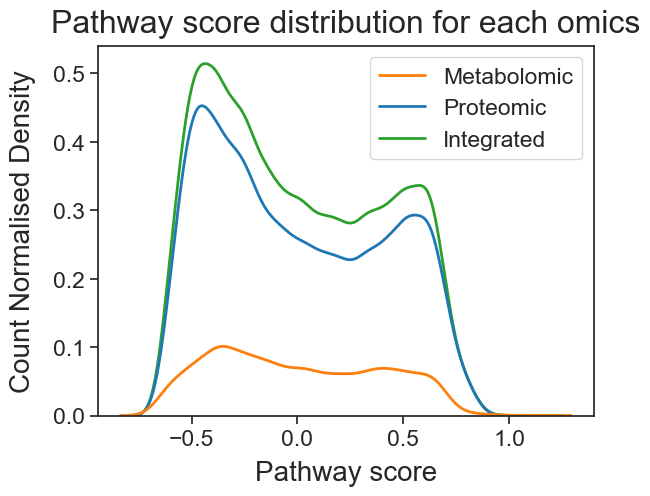

In [28]:
#Load in sequentially to form a density plot of the three different omics

sns.set(font_scale = 1.5)
sns.set_style("ticks") # same as "white" but with ticks

metabolomic_list = metabolomic_distribution.stack().reset_index()
metabolomic_list.columns.values[2] = "Metabolomic"

proteomic_list = proteomic_distribution.stack().reset_index()
proteomic_list.columns.values[2] = "Proteomic"

integrated_list = integrated_distribution.stack().reset_index()
integrated_list.columns.values[2] = "Integrated"

omics_df = pd.concat([metabolomic_list.Metabolomic, proteomic_list.Proteomic,integrated_list.Integrated], axis=1)

#Change because I want metabolomics to be orange, proteomics to be blue
palette = ['tab:orange', 'tab:blue', 'tab:green']

sns.kdeplot(data=omics_df, palette=palette, linewidth=2)
plt.title('Pathway score distribution for each omics',  fontsize=23, pad = 10)
plt.xlabel('Pathway score',fontsize=20, labelpad=8)
plt.ylabel('Count Normalised Density',fontsize=20, labelpad=12) ;

#plt.savefig( '../Figures/omics_pathway_distribution.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#PCA of pathway scores

features = kpca_scores.columns
x = kpca_scores.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

#display(df3)

sns.set(font_scale = 1.7)
sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['1-2', '3-4','5-7'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    palette=[ '#F4C441','#ff6d00', '#a30000'],    #yellow #F5AF2C #F6AE2D
   # scatter_kws={"s": 20} #point size
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend

sns.despine(right=False,top=False) #Add a line to the top and right of grid

#plt.title('Pathway scores',fontsize=16, loc='left', pad=10)
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=24)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=24)

legend_labels = ["1-2 \n'Mild'", "3-4 \n'Severe'", "5-7 \n'Severe'"]

#plt.legend(labels = legend_labels,framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 20}, bbox_to_anchor=(1.8, 0.7),markerscale=2)
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

plt.grid() 

#plt.savefig( '../Figures/integrated_kPCA_PCA.png' , dpi=600,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( '../Figures/legend.png' , dpi=600,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



In [ ]:

plt.rcParams['font.family']
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

Make a PCA plot on the integrated data showing separation of metabolomic and proteomic pathways:

In [76]:
#Read in omics pathway sequentially

metabolomic_pathways# = kpca_scores.columns
#proteomic_pathways = kpca_scores.columns

In [114]:
integrated_df =  (kpca_scores).transpose()

analyte_list = []
counter = 0
for i in integrated_df.index:
    #print(i)
    if i in metabolomic_pathways and i not in proteomic_pathways:
        analyte_list.append("Metabolite")
        
    if i in proteomic_pathways and i not in metabolomic_pathways:
        analyte_list.append("Protein")
        counter += 1

    if (i in proteomic_pathways and i in metabolomic_pathways) or (i not in proteomic_pathways and i not in metabolomic_pathways):
        analyte_list.append("Both")

len(analyte_list)

710

In [115]:
len(set(metabolomic_pathways).intersection(set(proteomic_pathways)))

47

In [116]:


#PCA at molecular level
features = integrated_df.columns
x = integrated_df .loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(integrated_df.index)
display(df2)

#Concatenate WHO information

df2['Omics'] = analyte_list

display(df2)


,PC1,PC2
R-HSA-109581,-2.459893,0.223859
R-HSA-109606,-2.789929,-0.942704
R-HSA-109704,-1.213402,-0.660525
R-HSA-110331,1.231467,-0.799194
R-HSA-110362,2.034493,3.187040
...,...,...
R-HSA-983169,-1.832940,-1.667371
R-HSA-983231,5.325437,2.539172
R-HSA-983695,-2.845104,0.354100
R-HSA-983705,-2.569050,-0.136683


,PC1,PC2,Analyte
R-HSA-109581,-2.459893,0.223859,Protein
R-HSA-109606,-2.789929,-0.942704,Protein
R-HSA-109704,-1.213402,-0.660525,Protein
R-HSA-110331,1.231467,-0.799194,Metabolite
R-HSA-110362,2.034493,3.187040,Protein
...,...,...,...
R-HSA-983169,-1.832940,-1.667371,Protein
R-HSA-983231,5.325437,2.539172,Protein
R-HSA-983695,-2.845104,0.354100,Protein
R-HSA-983705,-2.569050,-0.136683,Protein


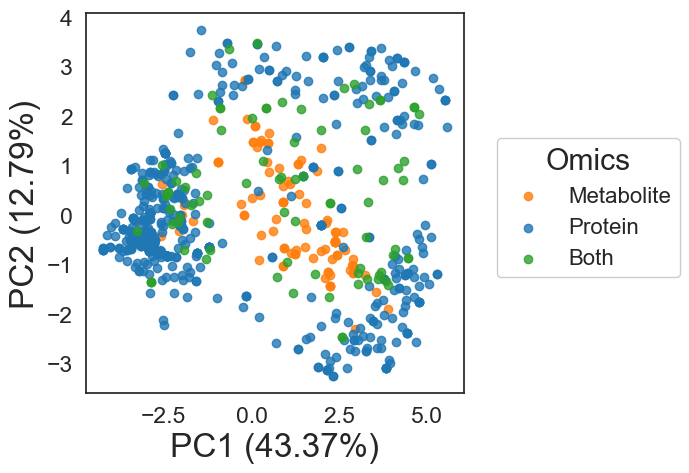

In [128]:

sns.set(font_scale = 1.5)
sns.set_style("white")

sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df2, 
    hue='Omics', 
    hue_order = ['Metabolite', 'Protein','Both'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    palette=[ '#ff7f0e','#1f77b4','#2ca02c']
   # scatter_kws={"s": 20} #point size
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend

sns.despine(right=False,top=False) #Add a line to the top and right of grid


#plt.title('Metabolomic dataset',fontsize=20,loc='center',y=1.08)
#plt.title('Metabolite abundance',fontsize=22, loc='left',pad=15)

plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=24)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=24)

plt.legend(framealpha=1, frameon = 'True', title="Omics",title_fontsize='large', prop={'size': 16}, bbox_to_anchor=(1.6, 0.7))  

### Spearman correlation coefficient

In [ ]:
kpca_scores

In [ ]:
#Note: Spearman correlation coefficient results are the same whether or not the kPCA pathway scores are normalised
#Create a table showing the Spearman correlation coefficient and the adjusted p-value for each edge

#"If axis=0 (default), then each column represents a variable, with observations in the rows"
spearman_results = scipy.stats.spearmanr(kpca_scores)

spearman_coef = spearman_results[0] #correlation coefficients
spearman_pvals = spearman_results[1] #p-values


#Using Sara's code (rather than having separate dataframes for each analysis, add all together in long format)
squared_spearman_coef_df = pd.DataFrame(spearman_coef,columns = kpca_scores.columns, index=kpca_scores.columns)
squared_spearman_coef_list = squared_spearman_coef_df.stack().reset_index()
squared_spearman_coef_list.columns = ["Pathway1", "Pathway2", "Spearman_corr"]
squared_spearman_coef_list["Squared_corr"]  = np.square(squared_spearman_coef_list.Spearman_corr)

spearman_pvals_df = pd.DataFrame(spearman_pvals,columns = kpca_scores.columns, index=kpca_scores.columns)
spearman_pvals_list = spearman_pvals_df.stack().reset_index()
spearman_pvals_list.columns = ["Pathway1", "Pathway2", "pval"]

#Multiple testing correction for the p-values to prepare the corrected p-values for the final correlation network
#Multiplies by the correct number of tests (i.e. not including the duplicates or self-comparisons)
#Does not remove the diagonals or the duplicates themselves
# E.g. ((160x160)-160)  / 2   (if there are 160 pathways)
num_of_tests = (len(kpca_scores.columns)**2 - len(kpca_scores.columns))/2
print(num_of_tests)
corrected_spearman_pvals = spearman_pvals_list.pval*num_of_tests
#If the p-val goes beyond 1 (max number for a p-value, change to 1)
corrected_spearman_pvals = np.where(corrected_spearman_pvals < 1, corrected_spearman_pvals, 1)
spearman_pvals_list["pval_adj"]  = corrected_spearman_pvals

spearman_df = squared_spearman_coef_list.merge(spearman_pvals_list,on=["Pathway1","Pathway2"])

display(spearman_df)

Bonferroni: https://avast.github.io/ep-stats/stats/multiple.html

Method 1: The alpha value (0.05) is divided by the number of tests (e.g. 225 pathways x 225 pathways = 50,625) and then the original p-vals are compared to the adjusted alpha value

Method 2: The alpha value remains unchanged and the individual p-values are adjusted (i.e. original p-value x number of tests) to increase them, and then compared to see if they cross the 0.05 significance level

After adjustment, some corrected p-values go up to 1 (the maximum)

In [ ]:
#Calculate number of significant values

#All self-comparisons are significant with a p-value of 0, so we can subtract those from the number of significant values before we divide by 2
sig_vals = (sum(i < 0.005 for i in spearman_df.pval_adj)-len(kpca_scores.columns))   /2
non_sig_vals = sum(i >= 0.005 for i in spearman_df.pval_adj)/2

print("Number of significant values:", sig_vals)
print("Number of non-significant values:", non_sig_vals)
(sig_vals/(sig_vals+non_sig_vals)) * 100

In [ ]:
#This function takes in dataframe, and masks one half and the diagonal to remove duplicates to prepare for a histogram plot
def duplicate_removal(df):
    #Mask the upper half of the dataframe (so I don't view the comparisons between the two same genes, and also the duplicate comparisons are removed)
    mask =  df.copy()
    mask = np.triu(np.ones(mask.shape)).astype(bool)
    mask = np.invert(mask) #invert true and false values so the diagonal is False as well
    non_dup_df = pd.DataFrame(df)
    non_dup_df = non_dup_df.where(mask) #Replace all false values with NaN using mask

    spearman_hist = non_dup_df.to_numpy().flatten()
    spearman_hist = spearman_hist[~np.isnan(spearman_hist)] #remove nan values

    return spearman_hist

In [ ]:
#Plot histogram of the squared Spearman correlation

squared_spearman_coef = np.square(spearman_coef)
#abs_spearman_coef = np.abs(spearman_coef)
spearman_hist = duplicate_removal(squared_spearman_coef) 

print(len(spearman_hist))
#https://cambiocteach.com/accessibility/colourchoice/   for colour palette
#orange #e69f00     sky blue #56b4e9    blue-green #009e73    (yellow #FFD580)
sns.histplot(spearman_hist, bins = 50,color='#e69f00',edgecolor="k")  

#plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Squared Spearman correlation',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/integrated_spearman_correlation_distribution_squared_non_dup.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plot heatmap of the squared Spearman correlation (idea from Sara's thesis)

#The reason for plotting as absolute or squared is that kPCA does not determine the directionality of effect
#Therefore the direction specified here is arbitrary i.e. negative pathway score does not mean downregulation of pathway


g = sns.clustermap(
    squared_spearman_coef,
    metric='euclidean', 
    method ="ward",
    cmap="OrRd",    #Spectral_r for normal,  OrRd for the other two
    xticklabels=False,
    yticklabels=False,
    figsize=(6,6),
    dendrogram_ratio=0.15, 
    vmin=0, 
    vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.1, 0.25, 0.03, 0.35])
g.cax.set_title("Correlation score",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font size of colourbar labels; 

#plt.savefig( 'Figures/squared_metabolite_spearman.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plot histogram of the Spearman p-values

np.seterr(divide = 'ignore')    
log_spearman_pvals = -np.log10(spearman_pvals)
np.seterr(divide = 'warn') 

spearman_pval_hist = duplicate_removal(log_spearman_pvals)  #Some inf values that are not plotted (too far along axis)
print(len(spearman_pval_hist))
sns.histplot(spearman_pval_hist, bins = 50,color='#56b4e9',edgecolor="k") 

#plt.title('Spearman p-value distribution',fontsize=16)
plt.xlabel('Squared Spearman correlation p-values (-log10)',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/integrated_spearman_pval_distribution_non_dup.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Overlap coefficients

I believe that sspa kPCA automatically filters out all pathways that have less than 2 compounds in them (confirmed since the pathway with the minimum number of metabolites had 2 compounds). When I filter out the compounds that are not in the dataset, I only include them into the new dictionary if the values have more than 1 compound.

In [ ]:
#Obtain pathways and corresponding metabolites for all Reactome pathways, store as dictionary
orig_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

#Filter out dictionary to retain only the pathways that remain after kPCA
my_keys = kpca_scores.columns
pathways_dict = {key: orig_dict[key] for key in my_keys}

In [ ]:
#Filter out the compounds in the pathways that are not present in the dataset

#Obtain all unique values in dataset
compounds_present = list(df.columns[:-2])
filtered_dict = {} 

#My code adapted from Cecilia's
#If the key values are not part of the compounds in dataset then remove
for key,value in pathways_dict.items():
    new_val = [item for item in value if item in compounds_present]
    if len(new_val) >= 2: #at least two compounds in the pathway
        filtered_dict[key] = new_val



In [ ]:
#Identifying all duplicate pathways from the Reactome pathway dictionary AFTER COMPOUNDS NOT IN PATHWAY REMOVED (the exact same metabolites, not subsets)

metabolites = list(filtered_dict.values())

from collections import Counter

c = Counter(map(tuple,metabolites))
dups = [k for k,v in c.items() if v>1]
result = [list(t) for t in dups]

for j in result:
    value = {i for i in filtered_dict if filtered_dict[i]==j}
    print(value)
    

In [ ]:
#Find the pathways with the minimum and maximum number of metabolites in pathways AFTER COMPOUNDS NOT IN PATHWAY REMOVED

max_len = max(metabolites, key=len)
print(len(max_len))

min_len = min(metabolites, key=len)
print(len(min_len))


for index in range(0,len(metabolites)):
    length = 4
    value = {key for key in filtered_dict if len(filtered_dict[key])==length}
print(value)

#len(filtered_dict['R-HSA-1430728'])

In [ ]:
#Checking Overlap coefficient code for the cell below

list1 = ['A','B','C','D','E','F','G']
list2 = ['A','B','C','J','K','L','M','N']
intersection = list(set(list1).intersection(list(set(list2))))  #set removes duplicates
numerator = len(intersection)

smaller_set = []
smaller_set.append(len(list1))
smaller_set.append(len(list2))
denominator = min(smaller_set)

val = (numerator/denominator)
print(val)

In [ ]:
#Difference between Jaccard similarity metric and S-S Overlap Coefficient
#https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient/

#Using Overlap Coefficient formula 

#I adapted my code by looking at Cecilia's comments
oc_matrix = np.zeros((len(my_keys),len(my_keys)))    

for i in range(0,len(my_keys)):   
    list1 = filtered_dict[my_keys[i]]
    
    for j in range(0,len(my_keys)):
        list2 = filtered_dict[my_keys[j]]

        # Szymkiewicz–Simpson coefficient
        #Find intersection between two lists
        intersection = len(list(set(list1).intersection(list(set(list2)))))
        smaller_set = min(len(list1), len(list2))

        val = intersection/smaller_set
        oc_matrix[i][j] = val 
        

In [ ]:
#Add overlap coefficient scores for each pathway pair 

oc_df = pd.DataFrame(oc_matrix, index=filtered_dict.keys(), columns=filtered_dict.keys())

oc_list = oc_df.stack().reset_index()
oc_list.columns = ["Pathway1", "Pathway2", "Overlap_coef"]
spearman_df = spearman_df.merge(oc_list,on=["Pathway1","Pathway2"])

display(spearman_df)

In [ ]:
#Calculate number of edges with values under to 0.5

#If looking at whole matrix (not accounting for self comparisons or duplicates)
#print(np.count_nonzero(oc_matrix < 0.5)/(len(my_keys)*len(my_keys)))

#Subtract by number of self-comparisons divided by 2
high_overlap = (np.count_nonzero(oc_matrix < 0.5) - len(my_keys)) / 2
unique_edges =  ((len(my_keys)*len(my_keys)) - len(my_keys)) / 2

print(high_overlap  /  unique_edges) 


In [ ]:
#Plot heatmap for the overlap coefficient (idea from Sara's thesis)

g = sns.clustermap(oc_matrix,
metric='euclidean', 
method ="ward",
cmap = "OrRd", 
xticklabels=False, 
yticklabels=False, 
figsize=(6,6),
dendrogram_ratio=0.2, 
vmin=-0, 
vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 
g2.set(yticklabels=[])  #remove tick labels
g2.tick_params(right=False) #remove ticks

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.25, 0.03, 0.35])
g.cax.set_title("Overlap Coefficient",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font size of colourbar labels; 

#plt.savefig( 'Figures/metabolite_overlap_coef.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plot histogram for the overlap coefficient

oc_hist = duplicate_removal(oc_matrix)
print(len(oc_hist))
sns.histplot(oc_hist, bins = 50,color='#009e73',edgecolor="k")   

#plt.title('Overlap coefficient distribution',fontsize=16)
plt.xlabel('Overlap coefficient',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/integrated_overlap_coef_distribution_non_dup.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plot figure showing data for Spearman correlation, Spearman p-value and for the overlap coefficient
import matplotlib.patches as patches

f, ax = plt.subplots()
points = ax.scatter(x=oc_hist, y=spearman_pval_hist,c=spearman_hist, s=6, cmap="viridis",alpha=0.3)

#Normal settings
cb = plt.colorbar(points, ticks=[0,0.2,0.4,0.6,0.8,1],shrink=0.5)   #shrink is redundant if you decide to set the position and size on next line
cb.ax.set_position([0.9, 0.28, 0.03, 0.35])
cb.ax.set_title('Spearman correlation',pad=10, size=10) #pad means the height of title away from colourbar

#Settings for legend only 
#cb = plt.colorbar(points, ticks=[0,0.2,0.4,0.6,0.8,1])#,shrink=1)
#cb.ax.set_position([1.1, 0.28, 0.5, 0.7])
#cb.ax.set_title('Spearman correlation',pad=10, size=17) #pad means the height of title away from colourbar
#cb.ax.tick_params(labelsize=15) 

plt.xlabel("Overlap coefficient",fontsize=15, labelpad=5)
plt.ylabel("Spearman p-values (-l0g10)",fontsize=15, labelpad=5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(0, 1.01)
#plt.ylim(-2, 100)    #metabolomic
#plt.ylim(-2, 170)   #proteomic and integrated

#Showing the cutoff (not sure if I'll include):

plt.axvline(x=0.5, color='r', linewidth=1, linestyle='--', dashes=(15, 4))
plt.axhline(y=-np.log10(0.005), color='r', linewidth=1, linestyle='--', dashes=(15, 4)) 

#rect = patches.Rectangle((0, 2.301), 0.5, 100, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)
#ax.add_patch(rect)

#ax.axvspan(0.5, 1, alpha=0.3)
#ax.axhspan(0, 2.301, alpha=0.3)

#plt.savefig('Figures/integrated_scatterplot.png' ,dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig('Figures/scatterplot_legend.png' ,dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Constructing overlap coefficient network graphs

In [ ]:
#Practice code
#Even for an edge going between two pathways, it's a single line here and in Cytoscape as well
#If you wanted to draw multiple edges going between the same two nodes, you would need to draw a multigraph
G = nx.Graph()

practice_df = {'Pathway1': ['A', 'B', 'C', 'D','D'], 'Pathway2': ['B','A','D','C','D'], 'weight': [1,1,2,5,3]}
pd.DataFrame(data=practice_df, index=[0, 1, 2, 3,4])

G = nx.from_pandas_edgelist(df=practice_df, source='Pathway1', target='Pathway2', edge_attr='weight')

nx.draw(G, with_labels = True)

#nx.write_gml(G, "test.gml")

Using Cecilia's code

Note: I don't remove the duplicate edges for the overlap coefficient graph, they seemed to be removed during NetworkX graph construction.
I do remove the diagonals though.

In [ ]:
#Remove self-correlations
spearman_df = spearman_df [spearman_df.Pathway1 != spearman_df.Pathway2]
spearman_df = spearman_df.reset_index(drop=True)
spearman_df

In [ ]:
#Overlap coefficient network
#I DON'T FILTER OUT ANY EDGES HERE: I FILTER IN CYTOSCAPE

#Add the nodes
G = nx.Graph()
G.add_nodes_from(oc_df.columns)

#does not deal with duplicates i.e.  Pathway 1 to Pathway 2 and vice versa
#but it's ok, because it shows up as one edge on the network in Cytoscape

G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Overlap_coef')

nx.draw(G, with_labels = True)
print(G.number_of_edges())
print(G.number_of_nodes())
#nx.write_gml(G, "Cytoscape/metabolomic_oc.gml")

### Final correlation network

Remember to take the corrected Spearman p-values

In [ ]:
spearman_df

#spearman_df.to_csv("Data/metabolomic_edgelist_df_all.csv")
#spearman_df.to_csv("Data/metabolomic_edgelist_df_commoncases.csv")

In [ ]:
#Making a pre-filtered network with all the edges

G = nx.Graph()
G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())


#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(spearman_df)):
    spearman_pval_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.pval_adj[i]
    overlap_coef_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.Overlap_coef[i]


nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

G.edges["R-HSA-110331","R-HSA-112310"]#["Spearman_pval"]

#nx.write_gml(G,'Cytoscape/metabolomic_prefiltered_commoncases.gml')
#nx.write_gml(G,'Cytoscape/metabolomic_prefiltered_severecases.gml')


In [ ]:
#Create EDGE ATTRIBUTES table to filter out unneeded edges

final_df = spearman_df[spearman_df["pval_adj"] < 0.005]  
final_df = final_df[final_df["Overlap_coef"] < 0.5]

print("Total correlation network: ",( (len(final_df)/2) / (len(spearman_df)/2))   * 100, "% of original")
final_df = final_df.reset_index(drop=True) 
display(final_df) #the duplicate edges have not been removed yet

#Can check the pathways prior to Overlap Coefficient filtering here
#final_df[final_df["Pathway1"] == "R-HSA-196854"]

Plot spearman correlation histogram to show edges AFTER filtering

In [ ]:
#Plot Spearman correlation to show edges AFTER filtering (optional)
 
#Remove duplicates in the edge list
final_df_copy = final_df.copy()

#Remove duplicate pathways
for i in range(0,len(final_df)):
    val1 = final_df.Pathway1[i]
    val2 = final_df.Pathway2[i]
    #print(val1,val2)
    #print(max(val1,val2))
    final_df_copy.Pathway1[i] = min(val1,val2)
    final_df_copy.Pathway2[i] = max(val1,val2)




print(len(final_df_copy))
spearman_hist = list(final_df_copy.Squared_corr)
sns.histplot(spearman_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Correlation score',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/metabolite_spearman_correlation_distribution_squared_afterfiltering_commoncases.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Identify isolated nodes (optional)

pathways_with_edges = set(final_df.Pathway1)
isolated_nodes = set(spearman_df.Pathway1) - set(pathways_with_edges) 
isolated_nodes
#len(pathways_with_edges)

In [ ]:
#Draw network graph with new edges

G = nx.Graph()
G = nx.from_pandas_edgelist(df=final_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())

In [ ]:
final_df

In [ ]:
#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(final_df)):
    spearman_pval_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.pval_adj[i]
    overlap_coef_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.Overlap_coef[i]
    
nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

#G.edges["R-HSA-110331","R-HSA-112310"]#["Spearman_pval"]



### Optional: Read in the full correlation network to display the differential network

For the differential network, we aren't trying to remove the edges based off of overlap or Spearman p-value, but it's interesting to see which edges are significant in the differential network which were filtered out in the original naive networks.

In [ ]:
G = nx.read_gml("Cytoscape/metabolomic_prefiltered_commoncases.gml")
with open('Data/permutation_test_files_metabolomics/not_sig_edges.txt') as f:
    lines = f.readlines()

In [ ]:
edges_to_remove = []

edges = lines[0].split(",")
edges

for index in range(0,len(edges),2):
    list1 = edges[index],(edges[index+1][1:])
    edges_to_remove.append(tuple(list1))

len(edges_to_remove)

In [ ]:
edges_to_remove

In [ ]:
G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())  
G.nodes()

In [ ]:
edges_to_remove_pval = [(u,v) for u,v,e in G.edges(data=True) if (e['Spearman_pval'] >= 0.005)]
print(len(edges_to_remove_pval))
edges_to_remove_pval

In [ ]:
edges_to_remove_oc = [(u,v) for u,v,e in G.edges(data=True) if (e['Overlap_coef'] >= 0.5)]
print(len(edges_to_remove_oc))
edges_to_remove_oc

In [ ]:
len(list(set(edges_to_remove_pval).intersection(set(edges_to_remove_oc)))) #After filtering out the nonsignificant edges from the permutations, 6 of the edges from the metabolomic common case dataset have Spearman p-val >= 0.005 and OC >= 0.5 

In [ ]:
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if (e['Spearman_pval'] >= 0.005 or e['Overlap_coef'] >= 0.5)]
G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())
G.nodes(data=True)

In [ ]:
nodes_to_remove = list(nx.isolates(G))
G.remove_nodes_from(nodes_to_remove)

### Setting node attributes

The betweenness centrality scores are the same whether or not the duplicates have been removed since the duplicate edges form the same edge when a graph is created

In [ ]:
#IF YOU DON'T REMOVE THE EDGES, DON'T RUN THIS CODE

#Add the betweenness centrality as a node attribute
betweenness= nx.betweenness_centrality(G, normalized=True) #output as dictionary
#display(betweenness)
nx.set_node_attributes(G, betweenness, "betweenness")

#Add the betweenness centrality as a node attribute
degree= nx.degree_centrality(G) #output as dictionary
#display(degree)
nx.set_node_attributes(G, degree, "degrees")


#Check
print(G.number_of_nodes()) 
#G.nodes['R-HSA-110331']#["betweenness"]

Setting the highest level of the pathway hierarchy 

In [ ]:
#Using Cecilia's code

#Creating graph
hierarchy = pd.read_csv('Data/ReactomePathwaysRelation.txt', sep='\t', header=None)

#From the pathways, subset to Homo sapiens only
hierarchy_hsa = hierarchy[hierarchy[0].str.contains('HSA')]

#Return unique values in the first column that is not in the second column as a numpy array
#These values are not child pathways in any instances
hierarchy_hsa_parents = np.setdiff1d(hierarchy_hsa[0], hierarchy_hsa[1])

#Add the unique values not in the second column as a second attached dataset to the bottom of the original data
#The first column represents the parent column, the second column is the child column
hierarchy_hsa_all = pd.concat([hierarchy_hsa, pd.DataFrame([hierarchy_hsa_parents, hierarchy_hsa_parents], index=[0, 1]).T])

#DiGraph is a directed graph
H = nx.from_pandas_edgelist(hierarchy_hsa, source=0, target=1, create_using=nx.DiGraph())


In [ ]:
#Using Cecilia's code

#Find the root pathway

def find_root(H,child):
    #Find parent from child 
    parent = list(H.predecessors(child))

    #Keep the loop going until the highest level is reached
    if len(parent) == 0:
        return child
    else:  
        return find_root(H, parent[0])

hierarchy_hsa_all['Root'] = [find_root(H, i) for i in hierarchy_hsa_all[1]]

hierarchy_hsa_all.columns = ['Parent', 'Child', 'Root']

#There are 83 instances of duplicates, however all the child duplicates have the same root (even though different parents) after checking

root_pathways = {}
for pathway in list(H.nodes):
    index = hierarchy_hsa_all.Child[hierarchy_hsa_all.Child == pathway].index.tolist()[0]
    root_pathway  = hierarchy_hsa_all.Root[index]
    label = root_pathway_dict[root_pathway]
    root_pathways[pathway] = label


In [ ]:
#Using Cecilia's code
 
#Shows all the root pathways in Reactome
set(hierarchy_hsa_all['Root'] )
#Shows all the root pathways present in the original dataset
set(root_pathways.values())

nx.set_node_attributes(G, root_pathways, "root_pathway")

print(G.number_of_nodes()) 

In [ ]:
#Clustering with Louvain algorithm

#For some reason, not sure if really clustering by weight since it works with a typo 
#I think it works though, since changing the name gives a diff num of clusters even with seed set
#Resolution = 1 is the default, increasing resolution will yield more communities
louvain_clusters = nx.community.louvain_communities(G, weight='Squared_corr',seed=100,resolution=1.2)
print(len(louvain_clusters))

louvain_dict = {}
for index,grouping in enumerate(louvain_clusters):
    for pathway in grouping:
        louvain_dict[pathway] = index+1

nx.set_node_attributes(G, louvain_dict, "louvain")
    

In [ ]:
#Assign pathway name to node

pathway_name_dict = {reactome_pathways.index[i]:reactome_pathways["Pathway_name"][i] for i in range(0,len(reactome_pathways))}
pathway_name_dict['R-HSA-1483257']
pathway_name_dict = {k:pathway_name_dict[k] for k in list(G.nodes)}

nx.set_node_attributes(G, pathway_name_dict, "pathway_name")

In [ ]:
#Check data before saving as network

print(G.number_of_nodes())
print(G.number_of_edges())

#print(G.nodes['R-HSA-110331'])#["betweenness"]
#print(G.edges["R-HSA-110331", "R-HSA-112310"])#["Spearman_pval"]

In [ ]:
#nx.write_gml(G,'Cytoscape/metabolomic_final_commoncases.gml')
#nx.write_gml(G,'Cytoscape/metabolomic_final_mildcases.gml')
#nx.write_gml(G,'Cytoscape/metabolomic_final_severecases.gml')

#nx.write_gml(G,'Cytoscape/proteomic_final_commoncases.gml')
#nx.write_gml(G,'Cytoscape/proteomic_final_mildcases.gml')
#nx.write_gml(G,'Cytoscape/proteomic_final_severecases.gml')

#nx.write_gml(G,'Cytoscape/integrated_final_commoncases.gml')
#nx.write_gml(G,'Cytoscape/integrated_final_mildcases.gml')
#nx.write_gml(G,'Cytoscape/integrated_final_severecases.gml')

Metabolomic: <br>
All common cases: 117 nodes, 724 edges <br>
Mild cases: 36 nodes, 132 edges <br>
Severe cases: 68 nodes, 198 edges <br>


Proteomic: <br>
All common cases: 563 nodes, 80,969 edges <br>
Mild cases: 405 nodes, 7,333 edges <br>
Severe cases: 522 nodes, 71,172 edges <br>


Integrated: <br>
All common cases: 666 nodes, 90,096 edges <br>
Mild cases: 424 nodes, 6,421 edges <br>
Severe cases: 589 nodes, 78,106 edges <br>